# Clasificador de mangos (maduros o podridos)
El problema consiste en la capacidad de clasificar un mango como maduro o podrido a partir de una image, se realizara un analisis de las variables que podemos usar y se probaran diferentes modelos para la resolución del problema comparando los disntintos resultados y sacar la conclusión necesaria.
Los datos que se utilizarán para el entrenamiento de este modelo de clasificación consisten en imágenes de los dos tipos de mango (Maduro y Podrido). 
A continuación, se presentará cuantas imágenes de cada grupo se utilizarán para el entrenamiento y la evaluación.

## Variables que se usaran
Las caracteristicas que decidimos usar para el entramiento de modelos son:
- Los diferentes tipos de efecto blur que pueda tener la imagen
- Numero de euler
- Entropia de Shannon
- Media del histograma del gradiente orientado
- Varianza del histograma del gradiente orientado
- La intensidad media
- La varianza de la intensidad


In [ ]:
%pip install matplotlib scikit-learn scikit-image numpy scipy pandas seaborn tensorflow keras

Para la visualización de la cantidad de datos usaremos pyplot de la libreria matplotlib, esta nos permite generar histogramas para poder observar como se encuentran distribuidos dichos datos. En este caso estaremos usando las imagenes que tengamos disponibles de mangos.

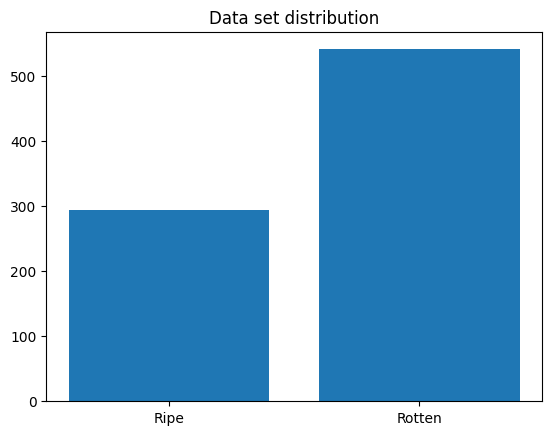

In [6]:
import os
import matplotlib.pyplot as pyplot

dirs = ['mangos_mascaras']
categories = ['Ripe', 'Rotten']

image_count = {}

for directory in dirs:
    count = 0
    for category in categories:
        image_count.setdefault(directory, {})
        image_count[directory][category] = len(os.listdir(os.path.join(directory, category)))

pyplot.title('Data set distribution')
pyplot.bar(image_count['mangos_mascaras'].keys(), image_count['mangos_mascaras'].values())
pyplot.show()

# Cargado de las imágenes en escala de grises y aplicación de las máscaras correspondientes
Para la extracción y procesamiento de las imagenes y ponerle sus respectivas mascaras, usaremos numpy para leer las mascaras como matrices de numeros y se utilizara skimage para leer las imagenes y mascaras, poder convertirlas a escala de grises y al final juntar ambas como es debido.
Este código se encarga de cargar, procesar y filtrar imágenes de mangos maduros y podridos junto con sus máscaras de segmentación correspondientes, utilizando diversas funciones de bibliotecas como skimage, numpy y pandas. Primero, carga las imágenes con la función ski.io.imread() y las convierte a escala de grises mediante ski.color.rgb2gray() o ski.color.rgba2gray() según sea necesario. Las máscaras se cargan con np.load() y se convierten a tipo ubyte utilizando ski.util.img_as_ubyte(). Si las dimensiones de las máscaras no coinciden con las de las imágenes, se redimensionan mediante skimage.transform.resize(). Luego, se filtran los datos para eliminar imágenes cuyas máscaras sean inválidas o no coincidan en tamaño, utilizando una combinación de compresión de listas y la función filter(). Los datos válidos se organizan en un DataFrame de pandas con pd.DataFrame.from_dict(), y finalmente, se aplica la máscara a cada imagen mediante una multiplicación elemento a elemento (image * mask), para realizar la segmentación antes de su uso en modelos de clasificación. Al final se verifica si existen inconsistencias en las imagenes y mascaras como su tamaño que no sea (224,224) o que este mismo no coincida con el tamaño de su mascara.

In [4]:
import matplotlib.pyplot as plt
import skimage as ski
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import smart_resize

paths = ['mangos_mascaras/Ripe/', 'mangos_mascaras/Rotten/', 'mangos_mascaras/ripe_masks/', 'mangos_mascaras/rotten_masks/']

def load_mask(path, image_shape):
    try:
        mask = np.load(path)
        mask = ski.util.img_as_ubyte(mask)

        if len(mask.shape) == 3:
            mask = ski.color.rgb2gray(mask)

        # Redimensionar máscara al tamaño de la imagen si no coincide
        if mask.shape != image_shape:
            from skimage.transform import resize
            mask = resize(mask, image_shape, preserve_range=True, anti_aliasing=True).astype(np.uint8)

        return mask
    except Exception as e:
        print(f"Error al cargar máscara {path}: {e}")
        return None  # Retornar None si ocurre un error

def load_image(path):
    image = ski.io.imread(path)
    image = ski.util.img_as_ubyte(image)

    if len(image.shape) == 3 and image.shape[-1] == 4:
        image = ski.color.rgba2gray(image)
    
    if len(image.shape) == 3 and image.shape[-1] == 3:
        image = ski.color.rgb2gray(image)

    return image

labels = [
    *['Ripe' for _ in os.listdir(paths[0])],
    *['Rotten' for _ in os.listdir(paths[1])],
]

paths = [
    *[paths[0] + path for path in os.listdir(paths[0])],
    *[paths[1] + path for path in os.listdir(paths[1])],
]

images = [
    *[load_image(path) for path in paths]
]

image_set = list(zip(labels, images, paths))

masks = [
    load_mask(
        path.replace(label, label.lower() + '_masks').replace('.jpg', '').replace('.jpeg', '') +
        '_mask_mask_' + label.lower() + '.npy',
        image.shape  # Pasar la forma de la imagen
    )
    for label, image, path in zip(labels, images, paths)
]

# Filtrar máscaras no válidas (None)
valid_data = [(label, image, mask, path) for label, image, mask, path in zip(labels, images, masks, paths) if mask is not None]

# Crear DataFrame a partir de datos válidos
imageRaw = pd.DataFrame.from_dict({
    'labels': [item[0] for item in valid_data],
    'images': [item[1] for item in valid_data],
    'masks': [item[2] for item in valid_data],
    'paths': [item[3] for item in valid_data]
})
n_inconsistencias = 0
# Verificar dimensiones
for idx, (image, mask) in enumerate(zip(imageRaw['images'], imageRaw['masks'])):
    if image.shape != mask.shape or (image.shape != (224,224) or mask.shape != (224,224)):
        #print(f"Inconsistencia en el índice {idx}: imagen {image.shape}, máscara {mask.shape}")
        n_inconsistencias+=1

print(f"Numero de inconsistencias: {n_inconsistencias}")

Numero de inconsistencias: 69


## Ajuste de las imagenes con inconsistencias
Se hacen ajustes y redimensionamientos de las imagenes y mascaras con inconsistencias

In [25]:
# Redimensionar imágenes y máscaras a (224, 224) y asegurarnos de que las imágenes estén en escala de grises (1 canal)
target_size = (224, 224)
# Redimensionamos imágenes
images_resized = []
for img in imageRaw['images']:
    img = np.array(img)  # Convertimos a numpy
    if len(img.shape) == 2:  # Si es una imagen en escala de grises
        img = np.expand_dims(img, axis=-1)  # Añadimos la dimensión de canales
    # Redimensionamos la imagen a la forma deseada
    img_resized = smart_resize(img, target_size)
    img_resized.shape = np.squeeze(img_resized, axis=(2,)).shape
    images_resized.append(img_resized)

#images_resized = np.array(images_resized)

# Redimensionamos máscaras de la misma forma
masks_resized = []
for mask in imageRaw['masks']:
    mask = np.array(mask)  # Convertimos a numpy
    if len(mask.shape) == 2:  # Si es una máscara en escala de grises
        mask = np.expand_dims(mask, axis=-1)  # Añadimos la dimensión de canales
    # Redimensionamos la máscara a la forma deseada
    mask_resized = smart_resize(mask, target_size)
    mask_resized.shape = np.squeeze(mask_resized, axis=(2,)).shape
    masks_resized.append(mask_resized)

# Convertimos las máscaras redimensionadas a un arreglo numpy homogéneo
#masks_resized = np.array(masks_resized)
n_inconsistencias = 0
# Verificar dimensiones
for idx, (image, mask) in enumerate(zip(images_resized, masks_resized)):
    if image.shape != (224,224) or mask.shape != (224,224):
        n_inconsistencias+=1

print(f"Numero de inconsistencias: {n_inconsistencias}")
image_set = list(zip(labels, images_resized, masks_resized, paths))

# Quitamos las máscaras que no tienen la misma resolución que la imagen correspondiente
image_set = list(filter(lambda image: image[1].shape == image[2].shape, image_set))

image_set = [(label, image * mask, path) for label, image, mask, path in image_set]

Numero de inconsistencias: 0


Se verifica que efectivamente ya no hay inconsistencias

# Una breve inspección de las imágenes
Despues de juntar las imagenes con sus respectivas mascaras les podemos echar un vistazo utilizando matplot.

Este fragmento de código busca identificar y visualizar imágenes problemáticas en el conjunto de datos, comparando las rutas de archivo con las entradas en la lista found_errors. Para cada imagen en image_set, que contiene la etiqueta (label), la imagen segmentada (masked) y la ruta del archivo (path), el código verifica si la ruta contiene alguna de las rutas de error definidas. Si se encuentra una coincidencia, imprime la etiqueta y la ruta de la imagen, y luego utiliza matplotlib.pyplot.imshow() con el colormap 'gray' para mostrar la imagen segmentada. La visualización de la imagen permite inspeccionar visualmente las posibles anomalías o errores en las imágenes, como aquellas que pueden haber sido mal etiquetadas o que contienen datos corruptos.

Ripe
mangos_mascaras/Ripe/img368.jpg


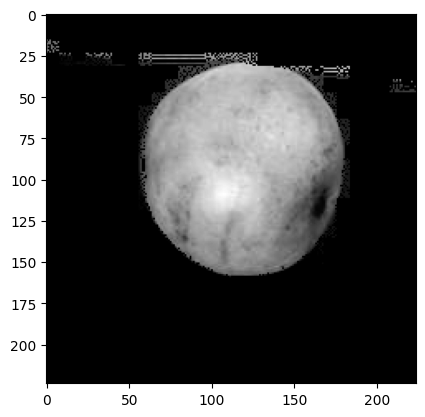

Rotten
mangos_mascaras/Rotten/img641.jpg


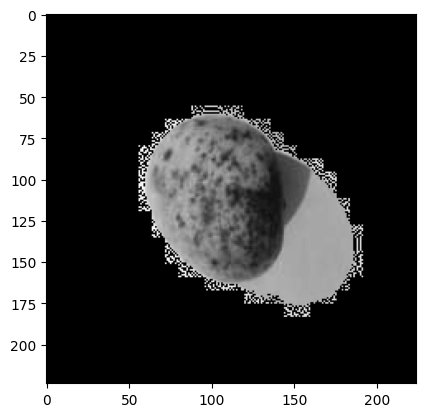

In [8]:
found_errors = ['Rotten/img641', 'Ripe/img368']

for label, masked, path in image_set:
    for error in found_errors:
        if error in path:
            print(label)
            print(path)
            plt.imshow(masked, cmap='gray'); plt.show()

# Extracción de características
En esta etapa procederemos a extraer las caracteristicas de las imagenes utilizando skimage con la funcion measure, esta permite sacar las caracteristicas que deseemos en todo el conjunto de imagenes.
Se incluyen métricas de textura y estructura como el efecto de difuminado (blur_effect), el número de Euler, la entropía de Shannon, el descriptor HOG, y medidas de intensidad como la media y la varianza de los píxeles. Estas características se organizan en un diccionario (feature_vector) y están listas para ser utilizadas en un modelo de clasificación para predecir si una imagen de mango es madura o podrida.

In [26]:
from statistics import mean, variance

feature_vector = {
    'category':             [label for label, image, path in image_set],
    'blur_efect_2':         [ski.measure.blur_effect(image, h_size=2) for label, image, path in image_set],
    'blur_efect_10':        [ski.measure.blur_effect(image, h_size=10) for label, image, path in image_set],
    'blur_efect_30':        [ski.measure.blur_effect(image, h_size=30) for label, image, path in image_set],
    'blur_efect_60':        [ski.measure.blur_effect(image, h_size=60) for label, image, path in image_set],
    'euler_number':         [ski.measure.euler_number(image, connectivity=4) for label, image, path in image_set],
    'shannon_entropy':      [ski.measure.shannon_entropy(image, base=2) for label, image, path in image_set],
    'hog_mean':             [mean(ski.feature.hog(image, orientations=4, feature_vector=True)) for label, image, path in image_set],
    'hog_variance':         [variance(ski.feature.hog(image,  orientations=4, feature_vector=True)) for label, image, path in image_set],
    'intensity_mean':       [mean(image.flatten()) for label, image, path in image_set],
    'intensity_variance':   [variance(image.flatten()) for label, image, path in image_set],
}


# Guardar el vector de caracterísitcas
Este fragmento de código utiliza pickle para guardar el diccionario feature_vector en un archivo binario llamado 'features.f'. La serialización de este diccionario permite almacenar las características extraídas de las imágenes de manera eficiente y cargarlas más tarde para evitar tener que recalcularlas cada vez que se necesiten

In [27]:
import pickle

with open('features.f', 'wb') as f:
    pickle.dump(feature_vector, f)
    f.close()

# Leer el vector de características
Una vez guardadas las caracteristicas que usaremos en un vector, procederemos a leerlas como un DataFrame utilizando pandas.
Este fragmento de código carga un archivo serializado que contiene el diccionario de características de las imágenes (features.f), lo convierte en un DataFrame de Pandas para facilitar su manipulación, y luego separa los datos en dos variables: X, que contiene las características de las imágenes (todas las columnas excepto la de la categoría), y Y, que contiene las etiquetas ("Ripe" o "Rotten"). Estos datos están ahora listos para ser utilizados en el entrenamiento de un modelo de clasificación.

In [28]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

with open('features.f', 'rb') as f:
    feature_vector_ = pickle.load(f)
    f.close()

image_data = pd.DataFrame.from_dict(feature_vector_)
image_data.info()

X = image_data.drop('category', axis=1)
Y = image_data['category']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category            835 non-null    object 
 1   blur_efect_2        835 non-null    float32
 2   blur_efect_10       835 non-null    float32
 3   blur_efect_30       835 non-null    float32
 4   blur_efect_60       835 non-null    float32
 5   euler_number        835 non-null    int64  
 6   shannon_entropy     835 non-null    float64
 7   hog_mean            835 non-null    float32
 8   hog_variance        835 non-null    float32
 9   intensity_mean      835 non-null    float32
 10  intensity_variance  835 non-null    float32
dtypes: float32(8), float64(1), int64(1), object(1)
memory usage: 45.8+ KB


In [29]:
image_data.describe()

,blur_efect_2,blur_efect_10,blur_efect_30,blur_efect_60,euler_number,shannon_entropy,hog_mean,hog_variance,intensity_mean,intensity_variance
count,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000
mean,0.697840,0.361534,0.231523,0.167119,-117.507784,3.689665,0.049026,0.008664,15.723774,1446.478882
std,0.041399,0.074084,0.068997,0.056874,61.921768,2.856711,0.031177,0.001897,20.295732,1595.503174
min,0.602129,0.237928,0.122847,0.064086,-364.000000,0.912024,0.014899,0.004339,0.018660,0.006597
25%,0.660967,0.291958,0.167277,0.114895,-143.500000,1.985852,0.029688,0.007254,0.249646,0.063625
50%,0.707932,0.357115,0.223028,0.162636,-111.000000,2.634272,0.038029,0.008563,10.794503,942.202881
75%,0.731454,0.424422,0.281234,0.209189,-86.000000,3.786729,0.052176,0.010070,20.231982,2277.745728
max,0.799684,0.537154,0.413343,0.307121,34.000000,14.205510,0.150729,0.013972,130.866241,7490.673828


In [30]:
image_data.isna().sum()

category              0
blur_efect_2          0
blur_efect_10         0
blur_efect_30         0
blur_efect_60         0
euler_number          0
shannon_entropy       0
hog_mean              0
hog_variance          0
intensity_mean        0
intensity_variance    0
dtype: int64

# Distribución de clases luego de la inspección
En este inciso, crea un gráfico de barras utilizando Seaborn para visualizar la distribución de las categorías de mango en el conjunto de datos. El countplot cuenta cuántas imágenes corresponden a la categoría "Ripe" (maduro) y "Rotten" (podrido), y muestra esta información en un gráfico de barras. El tamaño del gráfico es ajustado a 10x10 pulgadas, y se añade un título descriptivo para clarificar el propósito del gráfico.

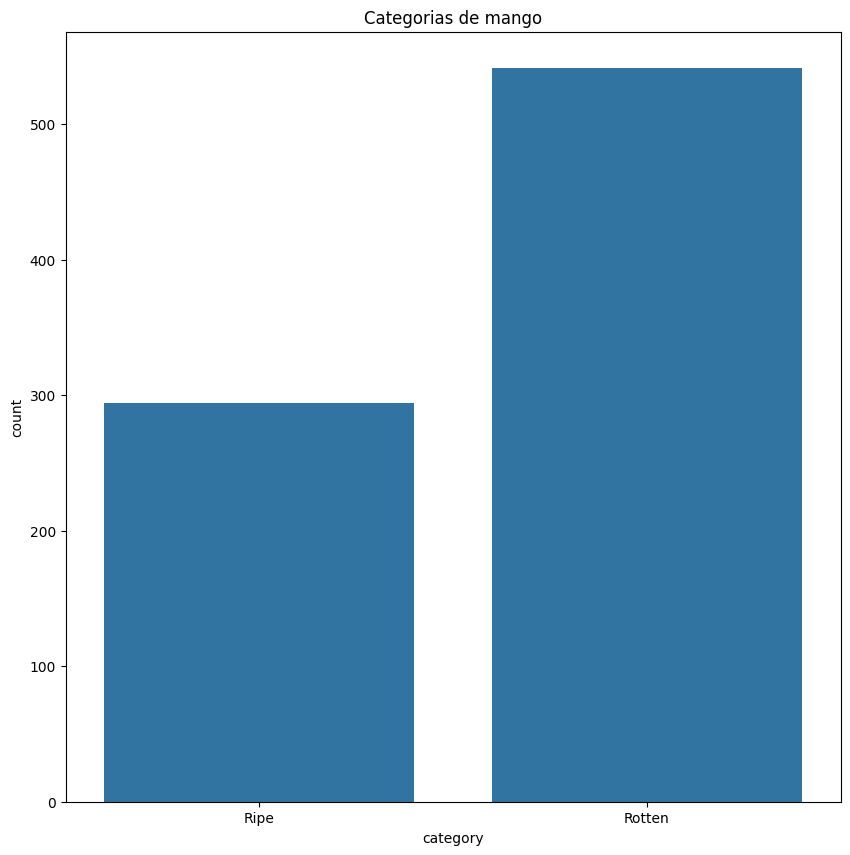

In [31]:
import seaborn as sns

ax = plt.subplots(1,1,figsize=(10,10))
sns.countplot(x='category',data=image_data)
plt.title("Categorias de mango")
plt.show()

# Distribución de las Variables Predictoras
Este fragmento de código crea un gráfico de barras utilizando Seaborn para visualizar la distribución de las categorías de mango en el conjunto de datos. El countplot cuenta cuántas imágenes corresponden a la categoría "Ripe" (maduro) y "Rotten" (podrido), y muestra esta información en un gráfico de barras. El tamaño del gráfico es ajustado a 10x10 pulgadas, y se añade un título descriptivo para clarificar el propósito del gráfico.


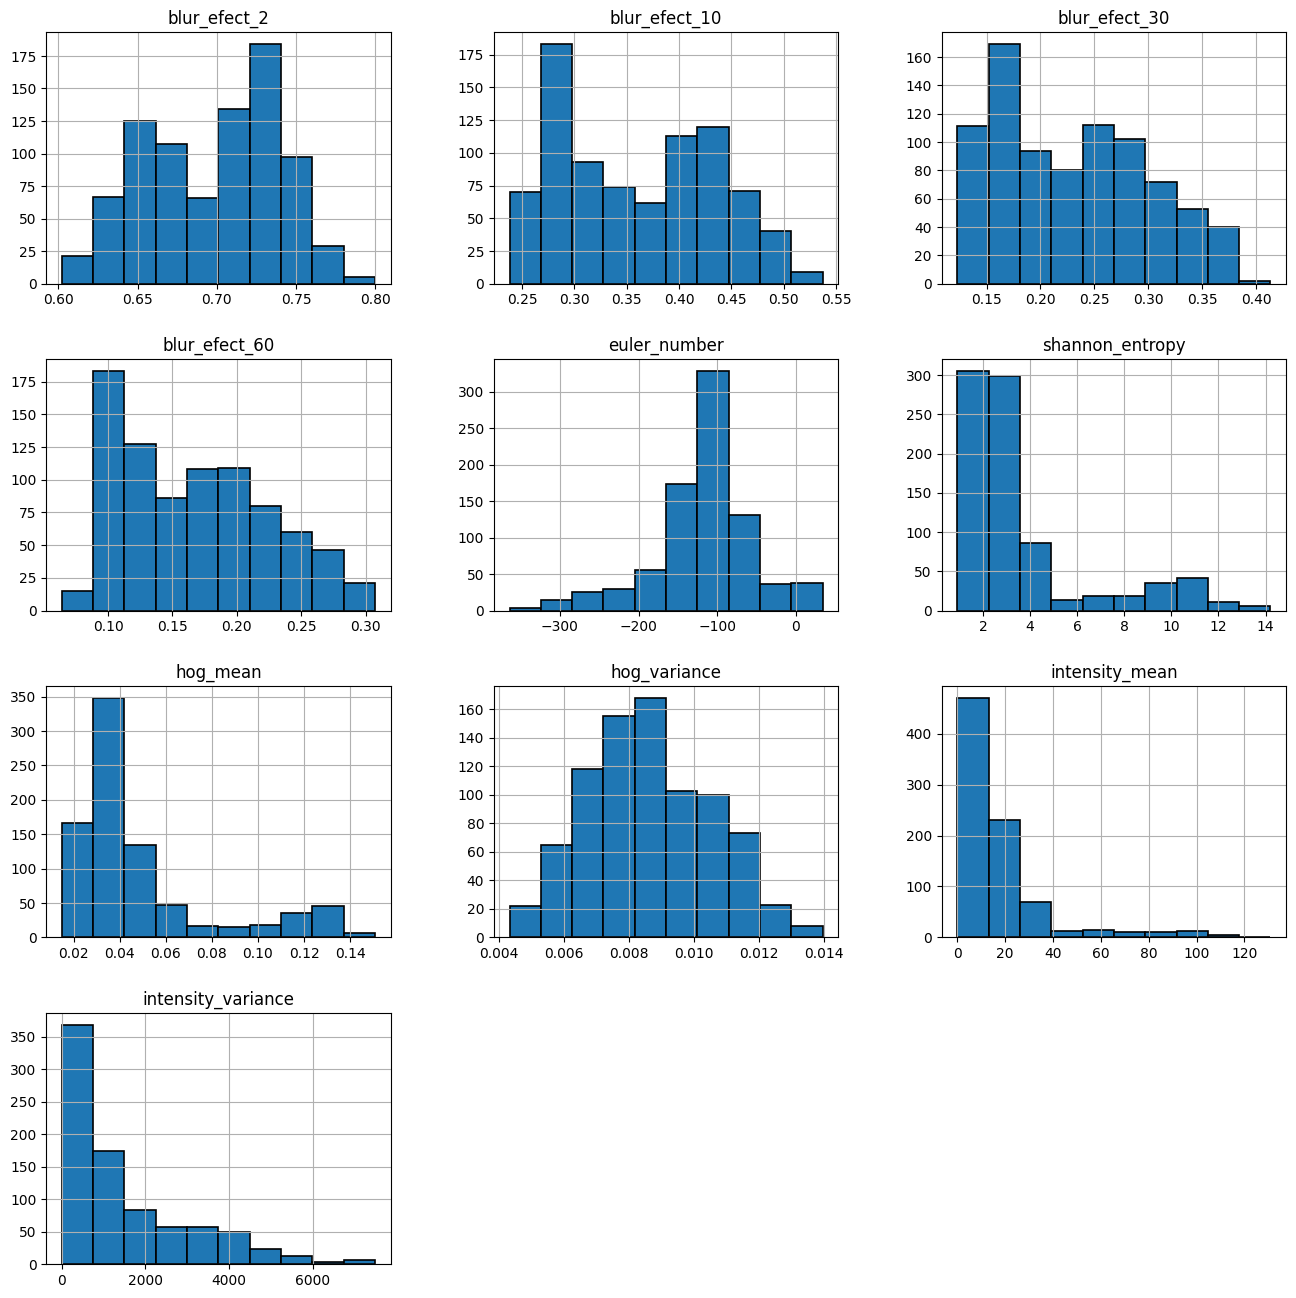

In [32]:
X.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(16,16)
plt.show()

# Inspección de variables predictoras correlacionadas
Este fragmento de código calcula la matriz de correlación de Spearman entre las columnas numéricas de X y luego genera un mapa de calor utilizando Seaborn para visualizar la intensidad de las correlaciones. Las celdas del mapa de calor se etiquetan con los valores de correlación y se aplica un esquema de colores divergente para representar las correlaciones positivas y negativas de manera clara. Finalmente, el gráfico se muestra utilizando plt.show().
El coeficiente de correlación de Spearman es útil para identificar relaciones monótonas entre variables, y el mapa de calor proporciona una visualización intuitiva para detectar patrones de correlación entre las variables de forma rápida. Este tipo de visualización es esencial para el análisis exploratorio de datos, especialmente cuando se busca comprender cómo se interrelacionan las distintas características de un conjunto de datos.

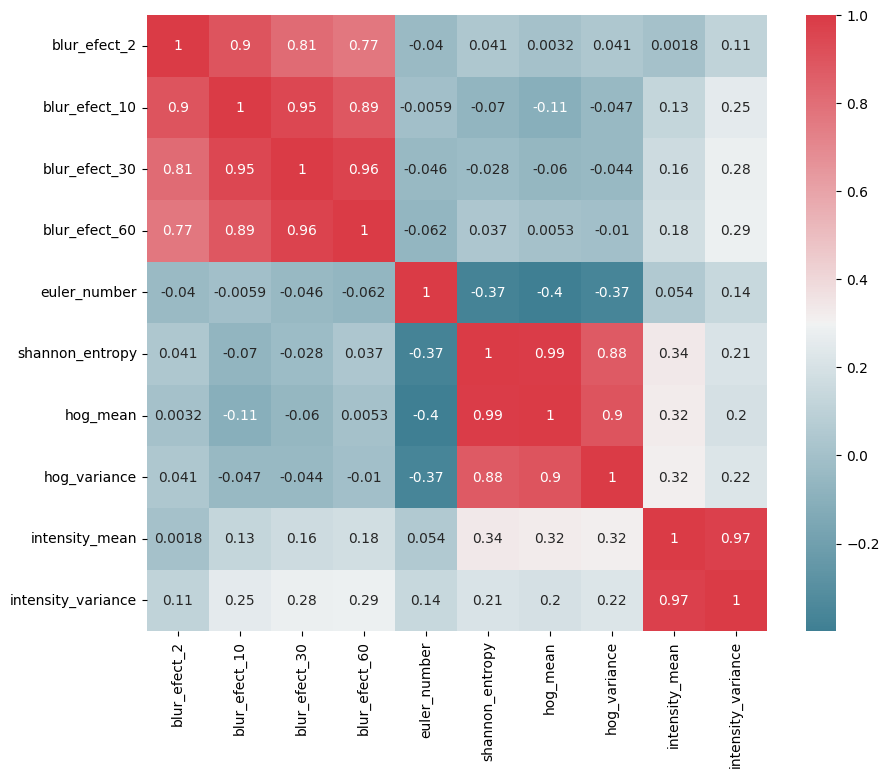

In [33]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr(method='spearman')
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)
plt.show() 

# Detección de la correlación en las variables predictorias
Aqui se proceden a detectar cuales son las variables correlacionadas y se agrupan, el nivel de correlación necesario que se usa es de 95%

In [34]:
def corr_feature_detect(data, threshold):
     
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] # remove the digonal
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            # find all features correlated to a single feature
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            # append the block of features to the list
            correlated_groups.append(correlated_block)
    return correlated_groups

In [35]:
corr = corr_feature_detect(data=X,threshold=0.95)
for i in corr:
    print(i,'\n')
if len(corr) == 0:
    print('No hay variables correlacionadas')

          feature1  feature2      corr
0  shannon_entropy  hog_mean  0.989252 

        feature1       feature2      corr
2  blur_efect_60  blur_efect_30  0.970871 

        feature1       feature2      corr
4  blur_efect_10  blur_efect_30  0.954594 



Con este resultado podemos observar que tres variables están fuertemente correlacionadas con otras variables del estudio, vamos a analizar en más detalles estás tres variables analizando gráficas de dispersión, y aplicando una prueba de correlación no paramétrica, dado que algunas de ellas no muestran una distribución normal.

array([[<Axes: xlabel='shannon_entropy', ylabel='shannon_entropy'>,
        <Axes: xlabel='hog_mean', ylabel='shannon_entropy'>,
        <Axes: xlabel='blur_efect_30', ylabel='shannon_entropy'>,
        <Axes: xlabel='blur_efect_60', ylabel='shannon_entropy'>,
        <Axes: xlabel='blur_efect_10', ylabel='shannon_entropy'>,
        <Axes: xlabel='blur_efect_2', ylabel='shannon_entropy'>],
       [<Axes: xlabel='shannon_entropy', ylabel='hog_mean'>,
        <Axes: xlabel='hog_mean', ylabel='hog_mean'>,
        <Axes: xlabel='blur_efect_30', ylabel='hog_mean'>,
        <Axes: xlabel='blur_efect_60', ylabel='hog_mean'>,
        <Axes: xlabel='blur_efect_10', ylabel='hog_mean'>,
        <Axes: xlabel='blur_efect_2', ylabel='hog_mean'>],
       [<Axes: xlabel='shannon_entropy', ylabel='blur_efect_30'>,
        <Axes: xlabel='hog_mean', ylabel='blur_efect_30'>,
        <Axes: xlabel='blur_efect_30', ylabel='blur_efect_30'>,
        <Axes: xlabel='blur_efect_60', ylabel='blur_efect_30'>,
   

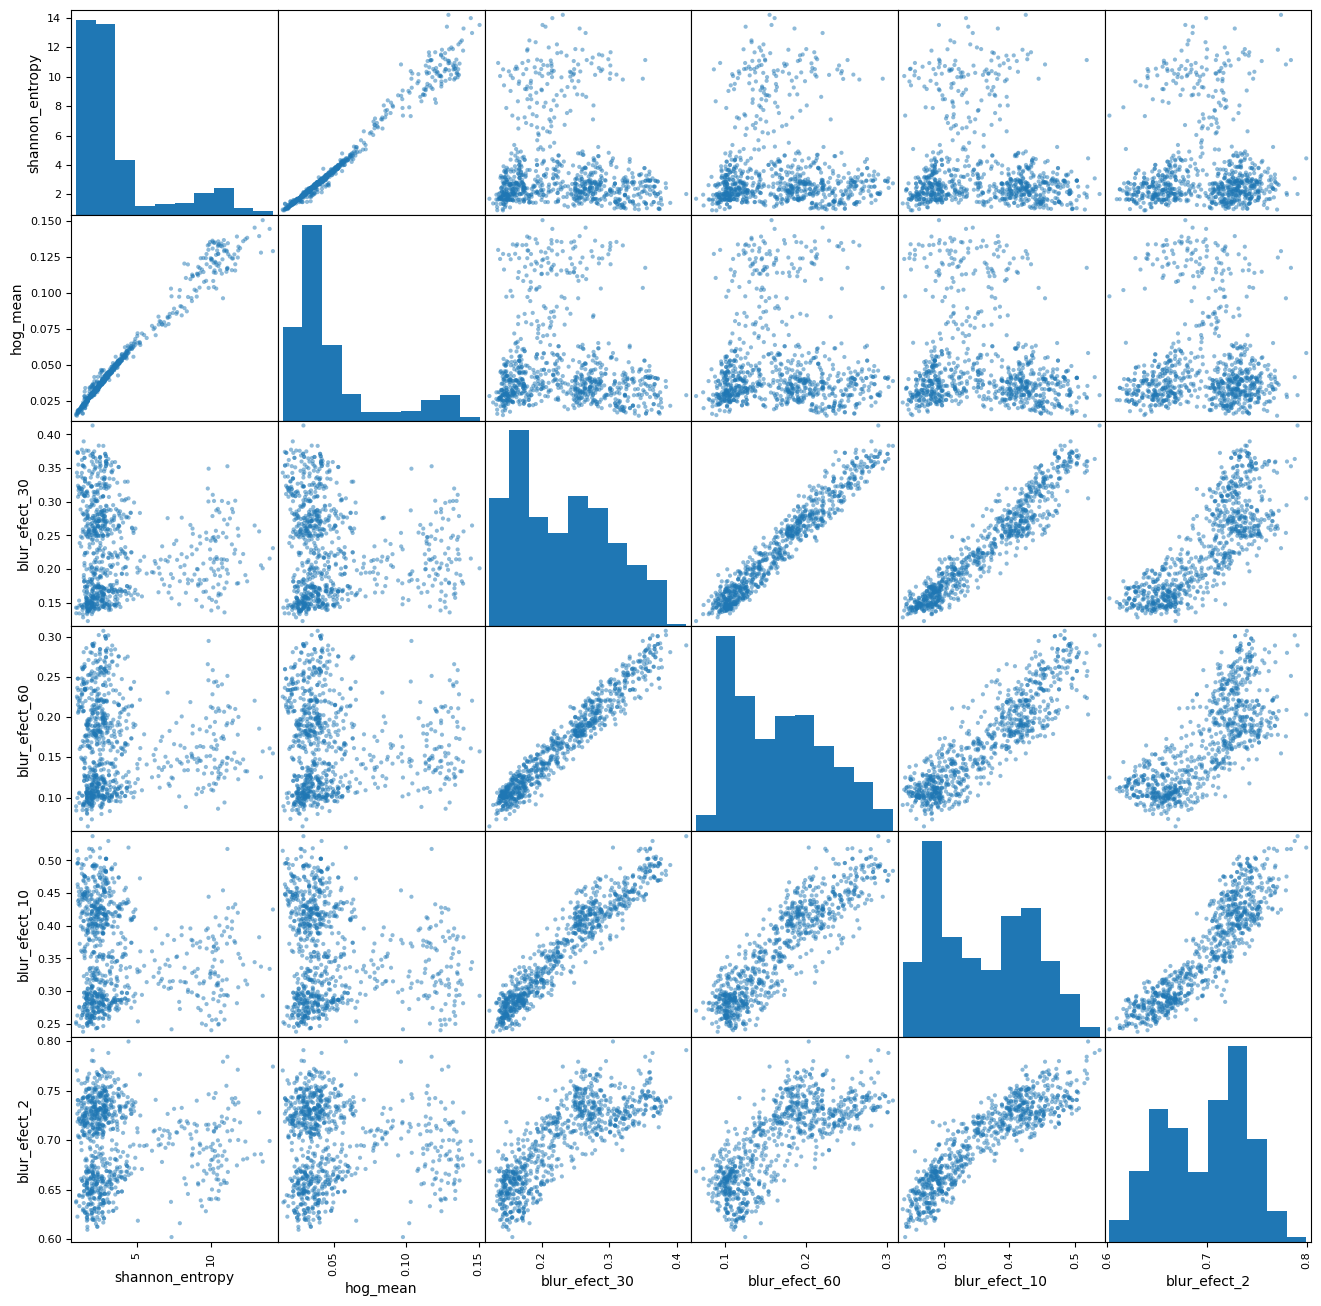

In [36]:
from pandas.plotting import scatter_matrix

cols = ['shannon_entropy', 'hog_mean', "blur_efect_30", 'blur_efect_60', 'blur_efect_10', 'blur_efect_2']
scatter_matrix(X[cols], figsize=(16, 16))

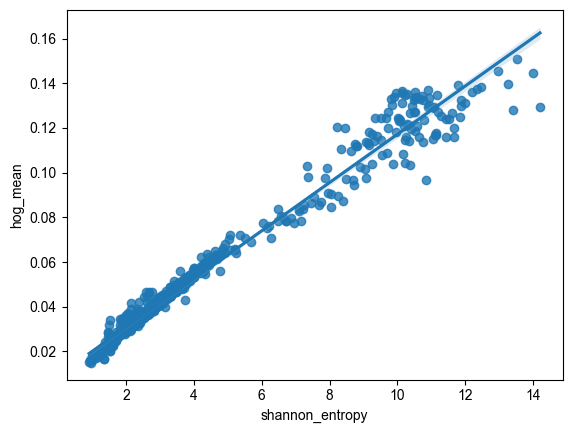

In [37]:
#Explorando un poco más la relación entre shannon entropy y hog mean
sns.regplot(x='shannon_entropy', y='hog_mean', data=X);
sns.set(rc={'figure.figsize':(2,5)})
plt.show()

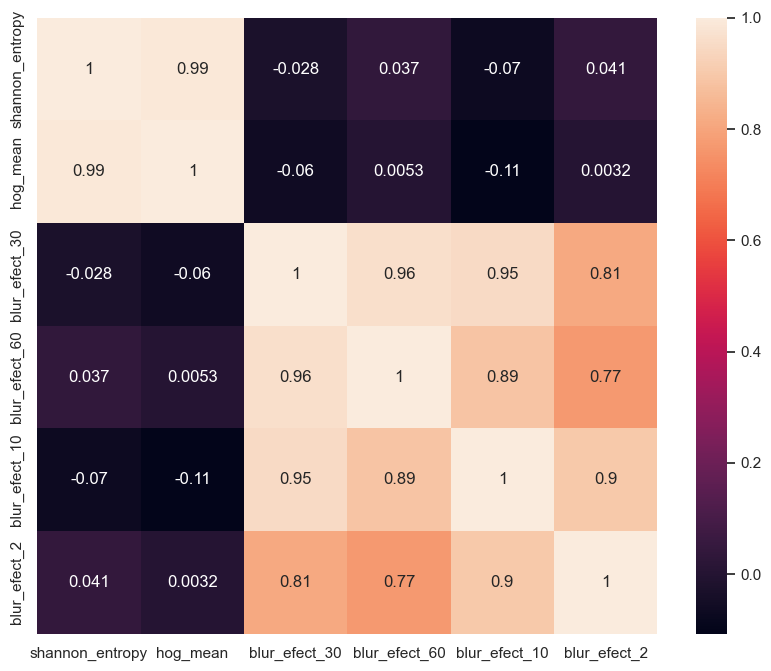

In [38]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X[['shannon_entropy', 'hog_mean', "blur_efect_30", 'blur_efect_60', 'blur_efect_10', 'blur_efect_2']].corr(method='spearman')
sns.heatmap(corr, annot=True)
plt.show()

La variable hog_mean está correlacionada de acuerdo al coeficiente de correlación de Spearman con la variable shannon_entropy.

In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_ = scaler.fit_transform(X)

In [80]:
# Partición del conjunto de datos en entrenamiento y prueba. 30% para pruebas
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_, Y, test_size=0.25, random_state=420)

# Clasificación usando Regresión Logística
Apartir de esta parte de código se entrena un modelo de regresión logística para clasificación utilizando el optimizador LBFGS. El modelo se ajusta a los datos de entrenamiento (Xtrain y Ytrain) sin penalización de regularización (penalty=None) y con un límite de 10,000 iteraciones para asegurar que el modelo converja. Este enfoque es adecuado para problemas de clasificación multiclase, como la clasificación de mangos en categorías (por ejemplo, maduro, podrido).

In [81]:
from sklearn.linear_model import LogisticRegression
softreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty=None, max_iter=10000)
softreg_model.fit(Xtrain, Ytrain)

C:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=10000, multi_class='multinomial', penalty=None)

In [82]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

Ytrain_predicted = softreg_model.predict(Xtrain)

print("Matriz de confusion para los datos de entrenamiento:\n%s" % metrics.confusion_matrix(Ytrain, Ytrain_predicted))
print('Accuracy', accuracy_score(Ytrain, Ytrain_predicted))

Matriz de confusion para los datos de entrenamiento:
[[194  25]
 [ 19 388]]
Accuracy 0.9297124600638977


In [83]:
Ytest_predicted = softreg_model.predict(Xtest)
print("Matriz de confusion para los datos de prueba:\n%s" % metrics.confusion_matrix(Ytest, Ytest_predicted))
print('Accuracy: ', accuracy_score(Ytest, Ytest_predicted))

Matriz de confusion para los datos de prueba:
[[ 63  12]
 [  9 125]]
Accuracy:  0.8995215311004785


Como se puede observar los resultados del modelo obtenido tanto en los datos de entrenamiento como en los datos de prueba son buenos, alcanzando un accuracy de 93% y 90% respectivamente en los casos.

# Lasso
Este fragmento de código entrena un modelo de regresión logística con regularización L1 (Lasso) para clasificación multiclase. Utiliza el optimizador SAGA para ajustar el modelo, penalizando la complejidad del modelo y favoreciendo soluciones con coeficientes más pequeños (y algunos igual a cero). El valor de C=1 controla la fuerza de la regularización, y el número máximo de iteraciones se establece en 5000 para asegurar la convergencia. Este enfoque es adecuado cuando se desea reducir la dimensionalidad del problema, descartas variables que no sean necesarias y mejorar la interpretabilidad del modelo, como en la clasificación de mangos en categorías.
Regularización L1 (Lasso) es especialmente útil cuando se cree que algunas de las características no son relevantes, ya que puede llevar algunos coeficientes a cero, efectivamente eliminando esas características del modelo.
El optimizador SAGA es muy eficiente en problemas con regularización L1 y es ideal para conjuntos de datos grandes y complejos.


In [84]:
softreg_lasso = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l1', C=0.5, max_iter=5000)
softreg_lasso.fit(Xtrain, Ytrain)

C:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.5, max_iter=5000, multi_class='multinomial',
                   penalty='l1', solver='saga')

In [85]:
y_train_predicted_softreg_lasso = softreg_lasso.predict(Xtrain)
y_test_predicted_softreg_lasso  = softreg_lasso.predict(Xtest)

print('Accuracy con los datos de entrenamiento: ', accuracy_score(Ytrain, y_train_predicted_softreg_lasso))
print('Accuracy: con los datos de prueba', accuracy_score(Ytest, y_test_predicted_softreg_lasso))

Accuracy con los datos de entrenamiento:  0.9297124600638977
Accuracy: con los datos de prueba 0.9138755980861244


Se puede obsevar que regularizando el modelo utilizando Lasso se obtienen resultados casi iguales pero aun siendo buenos con un accuracy de 93% y 91% respectivamente en los datos.

In [60]:
coefficients = softreg_lasso.coef_
zero_features_across_classes = np.all(coefficients == 0, axis=0)
zeroed_feature_indices = np.where(zero_features_across_classes)[0]
print(zeroed_feature_indices)

[5]


Se observa que las variables descartadas por Lasso son las de indice 5, que corresponden a Shannon Entropy

# Clasificación usando Arboles de decisión 
Este fragmento de código entrena un árbol de decisión multinomial con el criterio de entropía para clasificar las muestras. Evalúa el rendimiento del modelo mediante métricas como precisión, matriz de confusión, y reportes de clasificación. Además, utiliza GridSearchCV para optimizar los hiperparámetros del modelo, como la profundidad máxima del árbol, el criterio de división y el splitter. La optimización mejora la precisión en los datos de entrenamiento y prueba. Finalmente, se genera un mapa de calor de la matriz de confusión para visualizar el desempeño del modelo.
La matriz de confusión es útil para identificar cuántas predicciones fueron correctas o incorrectas por clase, lo que permite detectar posibles sesgos o problemas de clasificación en clases desbalanceadas.
El uso de GridSearchCV ayuda a mejorar el rendimiento del modelo, explorando múltiples combinaciones de hiperparámetros y seleccionando la más efectiva.

In [61]:
from sklearn import tree

decision_tree_model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=7)
decision_tree_model.fit(Xtrain, Ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [62]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Ypred = decision_tree_model.predict(Xtest)

accuracy = decision_tree_model.score(Xtest, Ytest)
accuracy_ = decision_tree_model.score(Xtrain, Ytrain)
cmatrix = confusion_matrix(Ytest, Ypred)

print('Matriz de confusión usando un árbol de decisión:')
print(cmatrix)
print('Accuracy: {:.2f}'.format(accuracy)) 
print('Accuracy (datos de entrenamiento): {:.2f}'.format(accuracy_)) 

print(classification_report(Ytest, Ytest))
print(X.columns)

Matriz de confusión usando un árbol de decisión:
[[ 69   6]
 [  9 125]]
Accuracy: 0.93
Accuracy (datos de entrenamiento): 0.99
              precision    recall  f1-score   support

        Ripe       1.00      1.00      1.00        75
      Rotten       1.00      1.00      1.00       134

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209

Index(['blur_efect_2', 'blur_efect_10', 'blur_efect_30', 'blur_efect_60',
       'euler_number', 'shannon_entropy', 'hog_mean', 'hog_variance',
       'intensity_mean', 'intensity_variance'],
      dtype='object')


Utilizando el metodo de arboles de decision en los datos se observa que tenemos unos resultados buenos al obtener un 93% de accuracy en los datos de prueba y un 99% en los datos de entrenamiento

In [63]:
# Número máximo de niveles en el árbol
max_depth = None,
criterion = ['gini', 'entropy', 'log_loss']
splitter = ['best', 'random']


In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': max_depth,
    'criterion': criterion,
    'splitter': splitter,            
}

decision_tree_grid = GridSearchCV(estimator=decision_tree_model, param_grid=param_grid, cv=2, verbose=2, n_jobs=2)
decision_tree_grid.fit(Xtrain, Ytrain)

print(decision_tree_grid.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
{'criterion': 'log_loss', 'max_depth': None, 'splitter': 'random'}


In [65]:
train_accuracy = decision_tree_grid.score(Xtrain, Ytrain) * 100
test_accuracy = decision_tree_grid.score(Xtest, Ytest) * 100

print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 92.344%


Utilizando GridSearchCV para hacer multiples pruebas con distintos parametros en el metodo de arboles de decision en los datos, despues de encontrar la más optima se observa que tenemos unos resultados buenos al obtener un 92% de accuracy en los datos de prueba y un 100% en los datos de entrenamiento

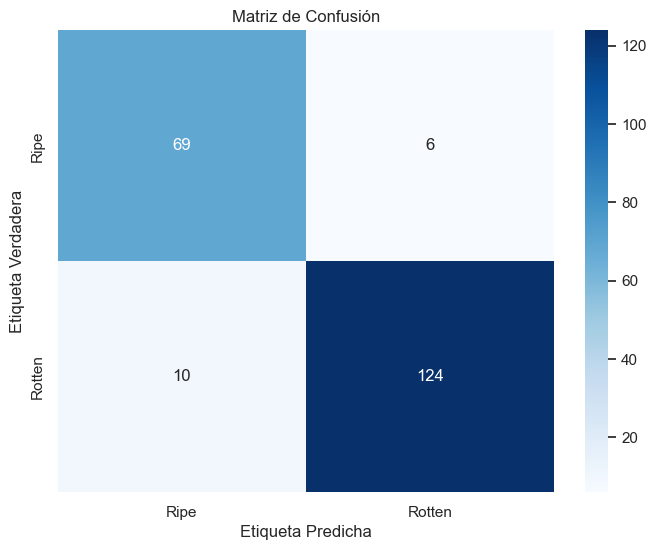

In [66]:
# Calcular la matriz de confusión
Ypred = decision_tree_grid.predict(Xtest)

cm = confusion_matrix(Ytest, Ypred)

labels = np.unique(Ytest)

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

# Clasificación usando Random Forest 
Este fragmento de código entrena un modelo de Bosque Aleatorio utilizando 17 árboles de decisión. Se aplica validación cruzada con 2 particiones para evaluar el rendimiento del modelo antes de ajustarlo a los datos de entrenamiento. Después de entrenar el modelo, se evalúa su precisión en los conjuntos de entrenamiento y prueba y se muestra el desempeño en cada uno. La precisión indica el porcentaje de predicciones correctas realizadas por el modelo, y la validación cruzada ayuda a obtener una estimación más confiable del rendimiento del modelo.

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

random_forest_model = RandomForestClassifier(n_estimators=17, random_state=28)
cross_val_scores = cross_val_score(random_forest_model, Xtrain, Ytrain, cv=2)
random_forest_model.fit(Xtrain, Ytrain)
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = random_forest_model.score(Xtrain, Ytrain) * 100
test_accuracy = random_forest_model.score(Xtest, Ytest) * 100

print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 100.000%
Precisión de prueba: 93.301%


Usando el metodo de Random Forest obtenemos resultados casi perfectos en los datos de entrenamiento (100%) y resultados buenos en los de prueba 93,3%

# Clasificación usando Random Forest 2
Al igual que el inciso anterior, este código entrena un modelo de Bosque Aleatorio, pero, con 6 árboles de decisión, utilizando validación cruzada con 2 particiones para evaluar el rendimiento del modelo en los datos de entrenamiento. Después de ajustar el modelo a los datos de entrenamiento, se evalúa su precisión en los conjuntos de entrenamiento y prueba. Además, se imprimen los resultados de la validación cruzada. La precisión indica el porcentaje de predicciones correctas, y la validación cruzada ayuda a estimar el rendimiento del modelo con un conjunto de datos limitado.

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

random_forest_model = RandomForestClassifier(n_estimators=6, random_state=12)
cross_val_scores = cross_val_score(random_forest_model, Xtrain, Ytrain, cv=2)
random_forest_model.fit(Xtrain, Ytrain)
# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba
train_accuracy = random_forest_model.score(Xtrain, Ytrain) * 100
test_accuracy = random_forest_model.score(Xtest, Ytest) * 100

print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))
print(cross_val_scores)

Precisión del entrenamiento: 99.201%
Precisión de prueba: 90.431%
[0.92332268 0.90415335]


Con esta configuración vemos como obtenemos un 99% con los datos de entrenamiento y un 90,4% en los datos de prueba

## Buscando la configuración optima de parámetros

In [69]:
# Número de árboles en el bosque aleatorio
n_estimators = [int(x) for x in np.linspace(start=2, stop=100, num=4)]
# Número de características a considerar en cada división
max_features = ['log2', 'sqrt']
# Número máximo de niveles en el árbol
max_depth = None,
# Número mínimo de muestras requeridas para dividir un nodo
min_samples_split = [5, 10]
# Número mínimo de muestras requeridas en cada nodo hoja
min_samples_leaf = [1, 2]

In [70]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,              
}

random_forest_grid = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=2, verbose=2, n_jobs=2)
random_forest_grid.fit(Xtrain, Ytrain)

print(random_forest_grid.best_params_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 67}


In [71]:
train_accuracy = random_forest_grid.score(Xtrain, Ytrain) * 100
test_accuracy = random_forest_grid.score(Xtest, Ytest) * 100

print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))

Precisión del entrenamiento: 99.840%
Precisión de prueba: 93.301%


Utilizamos nuevamente GridSearchCV para probar el modelo con distintas configuraciónes de parametros para encontrar la más optima y vemos que al final obtenemos una precisión de 99,84% en los datos de entrenamiento y un 93,3% en los datos de prueba

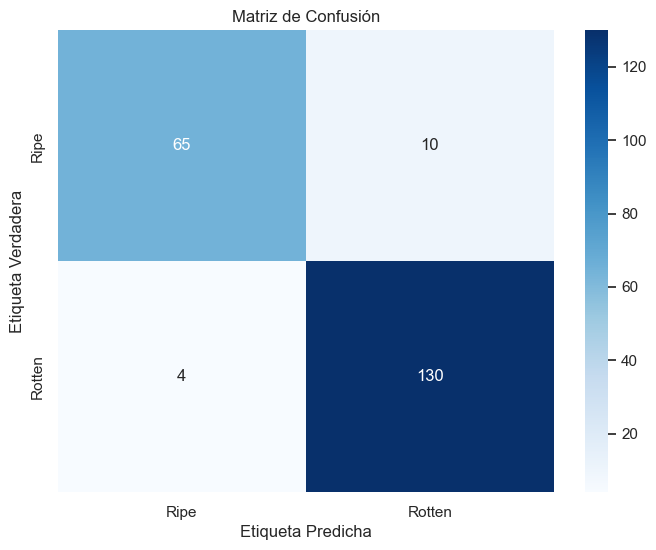

In [72]:
# Calcular la matriz de confusión
Ypred = random_forest_grid.predict(Xtest)

cm = confusion_matrix(Ytest, Ypred)

labels = np.unique(Ytest)

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

# Clasificación utilizando Redes Neuronales
Este fragmento de código entrena un modelo de Red Neuronal Multicapa (MLP) para clasificación. Primero, entrena el modelo con un conjunto de configuraciones de capas ocultas y parámetros de regularización, y luego evalúa el rendimiento en los datos de prueba calculando la precisión y la matriz de confusión. Posteriormente, se realiza una búsqueda en cuadrícula (GridSearchCV) para optimizar los hiperparámetros como las capas ocultas y alpha, y finalmente, se evalúa el modelo con los mejores hiperparámetros encontrados. La matriz de confusión se visualiza en un mapa de calor para facilitar su interpretación.
## Terminología Clave:
MLPClassifier: Red neuronal multicapa (Multilayer Perceptron) utilizada para clasificación.

hidden_layer_sizes: Configuración de las capas ocultas de la red neuronal (número de neuronas por capa).

alpha: Parámetro de regularización L2 que penaliza los pesos grandes.

max_iter: Número máximo de iteraciones que el modelo realizará para entrenar.

GridSearchCV: Herramienta de búsqueda en cuadrícula para encontrar la mejor combinación de hiperparámetros.

accuracy_score: Métrica que mide la precisión del modelo (porcentaje de predicciones correctas).

In [73]:
import warnings

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

model =  MLPClassifier(hidden_layer_sizes = (2,2), alpha=0.01, max_iter=1000) 
model.fit(Xtrain, Ytrain) #Training the model

MLPClassifier(alpha=0.01, hidden_layer_sizes=(2, 2), max_iter=1000)

In [74]:
#Test the model
predictions = model.predict(Xtest)
print(accuracy_score(Ytest, predictions))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(Ytest, predictions))

0.9282296650717703
Confusion matrix:
[[ 68   7]
 [  8 126]]


Vemos que obtenemos un accuracy de 93% con los datos de prueba.

## Buscando configuración optima de parametros
Ahora vamos a ajustar los parámetros del modelo utilizando GridSearch

In [75]:
param_grid = [{'hidden_layer_sizes' : [(3,3), (4,4), (5,4)], 'max_iter':[100, 500, 1000]}, 
              {'alpha': [0.0001, 0.001, 0.01, 0.1]}]

In [76]:
model = MLPClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(Xtrain, Ytrain)

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid=[{'hidden_layer_sizes': [(3, 3), (4, 4), (5, 4)],
                          'max_iter': [100, 500, 1000]},
                         {'alpha': [0.0001, 0.001, 0.01, 0.1]}],
             scoring='accuracy')

In [77]:
print(grid_search.best_params_)

{'hidden_layer_sizes': (4, 4), 'max_iter': 1000}


Despues de encontrar la configuración mas optima se procede a probarla

Accuracy:
0.937799043062201


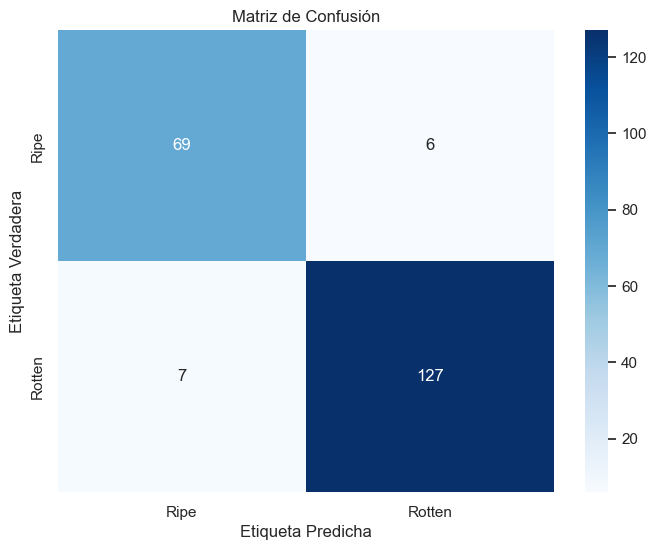

In [78]:
# Calcular la matriz de confusión
Ypred = grid_search.predict(Xtest)

cm = confusion_matrix(Ytest, Ypred)

labels = np.unique(Ytest)

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
print("Accuracy:")
print(accuracy_score(Ytest, Ypred))
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

Al final vemos que obtenemos un 93,7% de accuracy utilizando este modelo con la configuración más optima

# Clasificación utilizando Redes Neuronales Convolucionales

## Creación del modelo
Primeramente se creara un modelo con 5 capas convolucionales en la que cada una tendra su respectiva capa convolucional y de pooling utilizando la función de activación Relu, luego se aplana la ultima capa para recibir un vector, se le aplica un dropout y se conectan  todas las capas y al final se generan salidas usando la funcion de activación 'softmax', por ultimo se establece el optimizador que en nuestro caso es adam y la funcion de perdida que seria la entropia categorica cruzada.

In [100]:
import tensorflow as tf
from tensorflow.keras import layers, models
tf.config.run_functions_eagerly(True)

def crear_clasificador_mango(forma_entrada=(224, 224, 1), num_clases=2):
    modelo = models.Sequential()
    # Primera capa convolucional
    modelo.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same', input_shape=forma_entrada))
    modelo.add(layers.MaxPooling2D((2, 2)))
    # Segunda capa convolucional
    modelo.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))
    # Tercera capa convolucional
    modelo.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))
    # Cuarta capa convolucional
    modelo.add(layers.Conv2D(192, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))
    # Quinta capa convolucional
    modelo.add(layers.Conv2D(384, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))
    # Capas completamente conectadas
    modelo.add(layers.Flatten())
    modelo.add(layers.Dense(768, activation='relu'))
    # Funcion dropout
    modelo.add(layers.Dropout(0.5))
    # Capa de salida
    modelo.add(layers.Dense(num_clases, activation='softmax'))
    # Compilación del modelo
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return modelo
    
modelo = crear_clasificador_mango() #modelo
modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 24)        │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 112, 24)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 48)        │          10,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 96)          │          41,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 192)         │         166,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 384)         │         663,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 768)                 │      14,451,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,538 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,335,234 (58.50 MB)

 Trainable params: 15,335,234 (58.50 MB)

 Non-trainable params: 0 (0.00 B)

## Preparacion de los datos
Aquí aplicamos una técnica de preprocesamiento para enriquecer las entradas de entrenamiento del modelo, separamos nuestro set de imagenes para dividirlo en entrenamiento, validacion y pruebas y hacemos ajustes para que el modelo reciba los datos en el formato correcto.

In [101]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

#Al contener pocas imagenes se decidio optar por un batch_size reducido
batch_size = 18
image_size = (224, 224)

# Preprocesamiento
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

labels = []
images = []

for label, image, path in image_set:
    labels.append(label)
    if len(image.shape) == 2:  # Si es una imagen en escala de grises
        image = np.expand_dims(image, axis=-1)  # Añadimos la dimensión de canales
    images.append(image)


imagesnp = np.array([np.array(image) for image in images])  # Convertir imagenes enmáscaradas a NumPy
labelsnp = np.array(labels)  # Convertir etiquetas a NumPy

# Dividir los datos
X_train, X_temp, y_train, y_temp = train_test_split(imagesnp, labelsnp, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

label_map = {'Ripe': 0, 'Rotten': 1}
y_train_num = np.array([label_map[label] for label in y_train])
y_val_num = np.array([label_map[label] for label in y_val])
y_test_num = np.array([label_map[label] for label in y_test])

# Convertir las etiquetas numéricas a formato one-hot
y_train_one_hot = to_categorical(y_train_num, num_classes=2)
y_val_one_hot = to_categorical(y_val_num, num_classes=2)
y_test_one_hot = to_categorical(y_test_num, num_classes=2)

train_generator = train_datagen.flow(X_train, y_train_one_hot, batch_size=batch_size)
val_generator = val_datagen.flow(X_val,y_val_one_hot,batch_size=batch_size)

## Entrenamiento del modelo
Se entrena el modelo con 30 epocas y se guarda en un archivo este modelo entrenado.

In [102]:
# Entrenar el modelo
epochs = 30
history = modelo.fit(train_generator, epochs=epochs, validation_data=val_generator)

modelo.save('modelo_clasificador_mangos.h5') #modelo entrenado

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 878ms/step - accuracy: 0.5863 - loss: 0.6725 - val_accuracy: 0.6467 - val_loss: 0.6334
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 873ms/step - accuracy: 0.6386 - loss: 0.6053 - val_accuracy: 0.6347 - val_loss: 0.6413
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 885ms/step - accuracy: 0.6211 - loss: 0.6020 - val_accuracy: 0.5150 - val_loss: 0.6314
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 879ms/step - accuracy: 0.6588 - loss: 0.5746 - val_accuracy: 0.5569 - val_loss: 0.6483
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 860ms/step - accuracy: 0.6527 - loss: 0.5781 - val_accuracy: 0.6587 - val_loss: 0.6057
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 895ms/step - accuracy: 0.6740 - loss: 0.5482 - val_accuracy: 0.6707 - val_loss: 0.6152
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 852ms/step - accuracy: 0.6569 - loss: 0.5633 - val_accuracy: 0.6946 - val_loss: 0.6092
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 851ms/step - accuracy: 0.6653 - loss: 0.5647 - val_accu

## Prueba del modelo
Se carga el modelo entrenado y lo probamos con el conjutno de pruebas que habiamos guardado anteriormente. Al final se genera la matriz de confusión y el accuracy de los resultados

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step
Accuracy: 64.07%


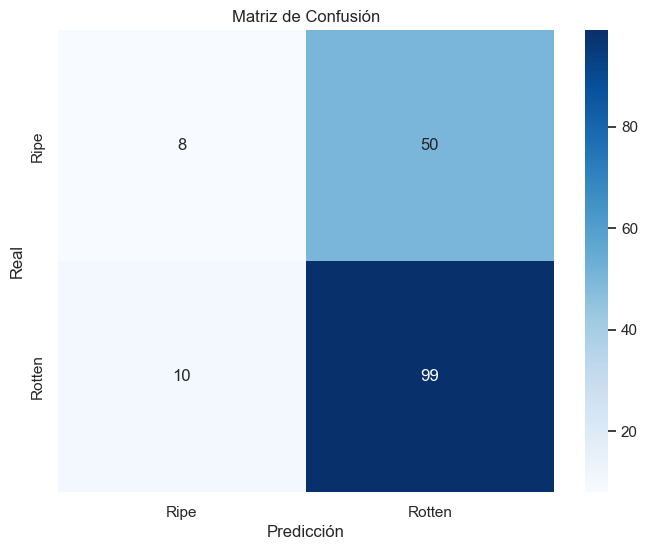

In [103]:
from sklearn.metrics import confusion_matrix
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

modelo = tf.keras.models.load_model('modelo_clasificador_mangos.h5')
categorias = ['Ripe', 'Rotten']

# Realiza las predicciones con los datos de test
y_pred_prob = modelo.predict(X_test)  # Predicciones en formato de probabilidades (para cada clase)

# Convierte las predicciones de probabilidades a las clases (0 o 1)
y_pred = np.argmax(y_pred_prob, axis=-1)  # La clase con la mayor probabilidad es la predicha

# Si tus etiquetas 'y_test' están en formato one-hot, conviértelas a las clases (0 o 1)
y_test_final = np.argmax(y_test_one_hot, axis=-1)  # Convertir one-hot a clases

# Genera la matriz de confusión
cm = confusion_matrix(y_test_final, y_pred)
accuracy = np.sum(y_test_final == y_pred) / len(y_test_final)
print("Accuracy: " + str(round(accuracy*100,2)) + "%")
# Visualiza la matriz de confusión usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ripe", "Rotten"], yticklabels=["Ripe", "Rotten"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Conclusiones
## 1. Regresión Logística
### Sin Regularización:
Precisión: ~90% en datos de prueba.
El modelo proporcionó un rendimiento inicial sólido, siendo adecuado como línea base. Sin embargo, mostró ciertas limitaciones en términos de generalización, especialmente en casos más complejos.
### Con Regularización Lasso (L1):
Precisión: ~91.3% en datos de prueba.
La inclusión de regularización mejoró ligeramente la precisión y ayudó a simplificar el modelo al eliminar características menos relevantes. Este enfoque ofreció una mejora modesta con respecto al modelo sin regularización.
## 2. Árbol de Decisión
Precisión: ~92,3% en datos de prueba.
Este modelo demostró un buen rendimiento inicial, con métricas de precisión, recall y F1-score equilibradas. Sin embargo, la precisión en los datos de entrenamiento fue significativamente alta (~99%), lo que sugirió un posible sobreajuste.
Si bien es intuitivo y fácil de interpretar, el modelo mostró limitaciones en su capacidad de generalizar, especialmente en comparación con modelos de conjunto como el Random Forest.
## 3. Random Forest
### Configuración con 6 Árboles:
Precisión: ~93.3% en datos de prueba.
Aunque se utilizaron pocos árboles, el modelo demostró un buen equilibrio entre sesgo y varianza, manteniendo un desempeño estable.
### Configuración con 12 Árboles:
Precisión: ~93.3% en datos de prueba.
Similar al modelo con 6 árboles tanto en prueba como entrenamiento, lo que sugiere que no mejora mucho utilizando mas arboles.
### Conclusión General para Random Forest:
Random Forest destacó como un modelo robusto y bien balanceado. Ofreció una mejora ligera con respecto al Árbol de Decisión individual al reducir el riesgo de sobreajuste y manejar relaciones no lineales entre características.
## 4. Redes Neuronales Multicapa (MLP)
Precisión: ~93.7% en datos de prueba.
Este modelo tuvo el mejor rendimiento general en términos de precisión y balance entre clases, con métricas sobresalientes para ambas categorías ("Ripe" y "Rotten").
La matriz de confusión mostró errores bajos en ambas clases, con solo 5 falsos negativos y 7 falsos positivos, lo que refleja un alto nivel de generalización.
Aunque computacionalmente más intensivo, el MLP sobresale en problemas complejos y demostró ser el modelo más efectivo en este proyecto.
## 5. Redes Neuronales Convolucionales (Deep Learning)
Mientras que en el caso de las redes neuronales convolucionales se obtuvo un rendimiento de 64,07% con los de prueba, lo que sugiere que el modelo cuenta con pocos datos para entrenamiento o requiere de mejores en los ajustes de parametros y configuración para alcanzar mejores resultados.